# Import Libraries

In [1]:
# !pip install evojax
# !pip install flax
# !pip install evosax
# !pip install pyDOE

In [2]:
import os
import numpy as np
import jax
import shutil
import jax.numpy as jnp
import logging
import time
import matplotlib.pyplot as plt
import pandas as pd
from jax import random, grad, vmap, hessian, jacfwd
from evojax import Trainer
from evojax.task.base import TaskState
from evojax.task.base import VectorizedTask
from evojax.policy.base import PolicyNetwork
from evojax.policy.base import PolicyState
from evojax.util import create_logger
from evojax.util import get_params_format_fn
from flax.struct import dataclass
from typing import Tuple
from flax import linen as nn
from jax.nn.initializers import xavier_uniform
from evojax.sim_mgr import SimManager
from flax.core.frozen_dict import unfreeze, freeze
# from pyDOE import lhs

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Directory to save logs and models

In [4]:
# Let's create a directory to save logs and models.
log_dir = 'loggerfiles'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('EvoJax for PINNs')

logger.info('Jax backend: {}'.format(jax.local_devices()))
#GPU count and name
!nvidia-smi --query-gpu=name --format=csv,noheader

NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


# Functions

In [5]:
@dataclass
# Contains the train input and its labels
class State(TaskState):
    obs: jnp.ndarray
    labels: jnp.ndarray
# function to generate analytical solution of IC
def f_ic(x):
    return 3*c1*(1 / jnp.cosh(a1*(x-x1)))**2 + 3*c2*(1 / jnp.cosh(a2*(x-x2)))**2
def third_deriviative(f):
    return jacfwd(jacfwd(jacfwd(f)))


In [6]:
v1 = 1
v2 = 0.001
# initial condition
c1, c2, x1, x2 = 0.3, 0.1, 0.4, 0.8
a1, a2 = 0.5*np.sqrt(c1/v2), 0.5*np.sqrt(c2/v2)

# spatial domain
x_l, x_u = 0., 1.5

# time domain: 0 - t_T
t_T = 2.0    

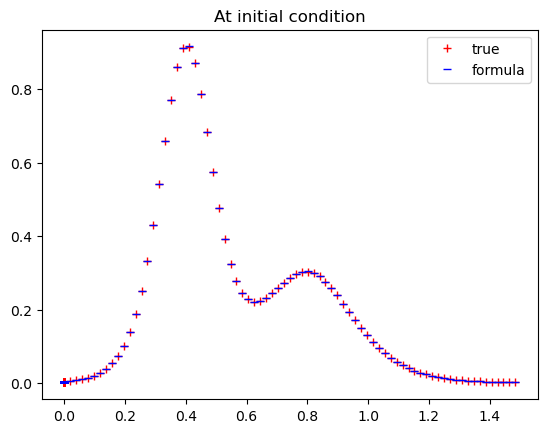

(15477, 1)

In [7]:
sim = pd.read_csv('kdv.csv')
# sim = pd.read_csv('/home/sungnwy/kdv plot/kdv.csv')
sim['x'], sim['t'] = sim['x'], sim['t']
x_train = np.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values
x = x_train[:,0:1].reshape(-1)
t = x_train[:,1:2].reshape(-1)
_train1 = np.argwhere(x <= 1.5)
x_train1 = x[_train1].reshape(-1)
t_train1 = t[_train1].reshape(-1)
y_train1 = y_train[_train1].reshape(-1)
_train2 = np.argwhere(x_train1 >= 0.0)
x_train2 = x_train1[_train2].reshape(-1,1)
t_train2 = t_train1[_train2].reshape(-1,1)
y_train2 = y_train1[_train2].reshape(-1,1)
batch_X = jnp.hstack([x_train2, t_train2])
batch_y = y_train2
x = batch_X[:,0:1].reshape(-1,1)
t = batch_X[:,1:2].reshape(-1,1)
_ic = np.argwhere(t == 0)
x_plot = x[_ic].reshape(-1)
u_true_plot = f_ic(x_plot) 
u_simu_plot = batch_y[_ic].reshape(-1)
plt.plot(x_plot, u_true_plot, '+r')
plt.plot(x_plot, u_simu_plot, '_b')
plt.legend(['true', 'formula'])
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('At initial condition')
plt.show()
x.shape

In [8]:

# Loss Function will be used as the fitness  (f=-L)
def loss(prediction, input):
  # essentially the new prediction here
    # [u,u_x, u_xx, u_xxx, u_t]
    x = input[:,0:1].reshape(-1,1)
    t = input[:,1:2].reshape(-1,1)
    u, u_x, u_xx, u_xxx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4], prediction[:,4:5]
    # ground truth
    t_u = f_ic(x) 
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
    ic_mse = jnp.sum(jnp.square((t_u-u)*_ic))/jnp.sum(_ic)
    # PDE (physics laws): u_t + v1*u*u_x + v2*u_xxx = 0   
    pde = u_t + v1*u*u_x + v2*u_xxx


    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde = pde*_pde
    pde_mse = jnp.sum(jnp.square(pde))/jnp.sum(_pde)
    pde_mse = pde_mse 
    loss = pde_mse + ic_mse
    return loss


# In[10]:


# Accuracy should not be used in this case, change to mean square error
def mse(prediction, target):
    u = prediction[:,0:1]
    
    mean_square_error = jnp.mean(jnp.square(u-target)) 
    return mean_square_error

# Task

In [9]:
class kdv(VectorizedTask):
    """PDE-NN for 1D convection-kdv equation.
    We model the regression as a one-step task, i.e., 
    `kdv.reset` returns a batch of data to the agent, the agent outputs
    predictions, `kdv.step` returns the reward loss) and
    terminates the rollout.
    """

    def __init__(self, batch_size, test):

        self.max_steps = 1

        # These are similar to OpenAI Gym environment's
        # observation_space and action_space.
        # They are helpful for initializing the policy networks.
        # Input shape is 2
        self.obs_shape = tuple([2, ])
        # Output shape is 1
        self.act_shape = tuple([1, ])


        # x = jnp.linspace(x_l, x_u, n)
        # PDE Data
        data_pde = batch_X
        labels_pde = batch_y
        # samples, features = data_pde.shape
        # 
        # _pde = np.reshape(eval_u(x, Pe, L),(-1, 1))
        # # BC data
        # bc = jnp.where((data_pde[:,0] == x_l) | (data_pde[:,0] == x_u))[0]
        # data_bc = jnp.take(data_pde, indices=bc, axis=0)
        # labels_bc = jnp.take(labels_pde, indices=bc, axis=0)

        def reset_fn(key):
            batch_data, batch_labels = data_pde, labels_pde
            # if test:
            #     # In the test mode, we want to test on the entire test set.
            #     batch_data, batch_labels = data_pde, labels_pde
            # else:
            #     # In the training mode, we only sample a batch of training data.
            #     batch_data, batch_labels = sample_batch(
            #         key, data_pde, labels_pde, data_bc, labels_bc, batch_size)
            return State(obs=batch_data, labels=batch_labels)
        
        # We use jax.vmap for auto-vectorization.
        self._reset_fn = jax.jit(jax.vmap(reset_fn))
        
        # step_fn needs to be changed
        def step_fn(state, action):
            if test:
                # In the test mode, we report the mean square error
                "change to training loss"
                # reward = loss(action, state.obs, state.labels)
                reward = mse(action, state.labels)
            else:
                reward = -loss(action, state.obs)       
            return state, reward, jnp.ones(())

        # We use jax.vmap for auto-vectorization.
        self._step_fn = jax.jit(jax.vmap(step_fn))
    # Returns a batch of data to the agent, the agent outputs predictions
    def reset(self, key):
        return self._reset_fn(key)
    # Returns the fitness loss
    def step(self, state, action):
        return self._step_fn(state, action)

In [10]:
seed = 1
batch_size = 498
train_task = kdv(batch_size=batch_size, test=False)
test_task = kdv(batch_size=batch_size, test=True)

# Policy

In [11]:
node = 8
class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    self.layers = [nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False),
                   nn.tanh,
                   nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      x, t = inputs[:,0:1], inputs[:,1:2]
      
      def get_u(x, t):
        u = jnp.hstack([x, t])
        for i, lyr in enumerate(self.layers):
          u = lyr(u)
        return u

      u = get_u(x, t)

      # obtain u_t
      def get_u_t(get_u, x, t):
        u_t = jacfwd(get_u, 1)(x, t)
        return u_t
      u_t_vmap = vmap(get_u_t, in_axes=(None, 0, 0))
      u_t = u_t_vmap(get_u, x, t).reshape(-1,1) 
      #obtain u_x
      def get_u_x(get_u, x, t):
        u_x = jacfwd(get_u)(x, t)
        return u_x
      u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
      u_x = u_x_vmap(get_u, x, t).reshape(-1,1)  
      #obtain u_xx    
      def get_u_xx(get_u, x, t):
        u_xx = hessian(get_u)(x,t)
        return u_xx
      u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
      u_xx = u_xx_vmap(get_u, x, t).reshape(-1,1)
      #obtain u_xxx    
      def get_u_xxx(get_u, x, t):
        u_xxx = third_deriviative(get_u)(x,t)
        return u_xxx
      u_xxx_vmap = vmap(get_u_xxx, in_axes=(None, 0, 0))
      u_xxx = u_xxx_vmap(get_u, x, t).reshape(-1,1)

      action = jnp.hstack([u,u_x, u_xx, u_xxx, u_t])   
      return action

In [12]:
class PINNsPolicy(PolicyNetwork):
    """A physics informmed neural neural network for the kdv task."""

    def __init__(self, logger: logging.Logger = None):
        if logger is None:
            self._logger = create_logger('PINNsPolicy')
        else:
            self._logger = logger

        model = PINNs()
        key1, key2 = random.split(random.PRNGKey(seed))
        a = random.normal(key1, [1,2]) # Dummy input
        params = model.init(key2, a) # Initialization call
        """Return a function that formats the parameters into a correct format."""
        self.num_params, format_params_fn = get_params_format_fn(params)
        self._logger.info(
            'PINNsPolicy.num_params = {}'.format(self.num_params))
        self._format_params_fn = jax.vmap(format_params_fn)
        self._forward_fn = jax.vmap(model.apply)

    def get_actions(self,
                    t_states: TaskState,
                    params: jnp.ndarray,
                    p_states: PolicyState) -> Tuple[jnp.ndarray, PolicyState]:
        params = self._format_params_fn(params)
        return self._forward_fn(params, t_states.obs), p_states
policy = PINNsPolicy(logger=logger)

# Solvers

CMA-ES Jax Solver

In [13]:
from evojax.algo import CMA_ES_JAX
popn = 50

solver = CMA_ES_JAX(
                pop_size=popn,
                param_size=policy.num_params,
                init_stdev=0.05,
                seed=seed,
                logger=logger)

# Training

In [14]:
max_iters = 25000 #50000//popn
num_tests = 1
t_fitness = 0

sim_mgr = SimManager(n_repeats=1,
			test_n_repeats=1,
			pop_size=popn,      
			n_evaluations= num_tests,
			policy_net= policy,
			train_vec_task=train_task,
			valid_vec_task=test_task,
			seed=seed)
loss_ls = []
t_training = []
# best_ls = []
# t_fitness = 0
# start_time = time.perf_counter()

runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.time()
    # Training.
    params = solver.ask()
    # This is where fitness is calculated, want to get the time
#     start = time.time()
    scores, _ = sim_mgr.eval_params(params=params, test=False)
#     end = time.time()
#     t_fitness = t_fitness + (end-start)
    
    # Updates the weights through the solver
    solver.tell(fitness=scores)
    # This is the average loss of all the population of parameters
    score_avg_loss = np.mean(np.array(scores, copy=False, subok=True))
    best_params = solver.best_params
    end = time.time()
    t_training.append(end-start)
    loss_ls.append(-1*score_avg_loss)
    # update
    runtime += end-start
    train_iters += 1
    

In [15]:
training_ls = np.cumsum(t_training)
training_ls

array([ 3.67011142,  4.33425355,  4.34224796, ..., 59.98632503,
       59.99356675, 60.00080991])

# Plot of loss/mse against iterations

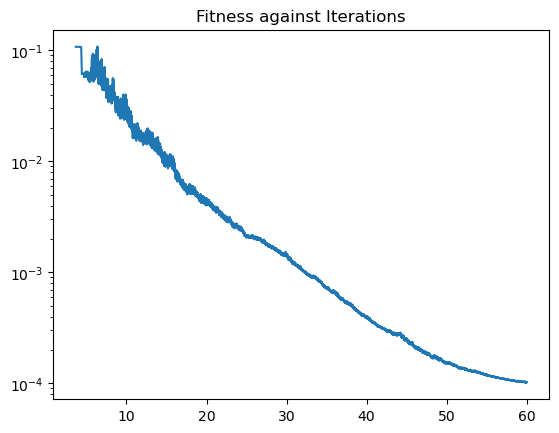

In [16]:
plt.plot(training_ls, loss_ls); plt.yscale('log');
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('Fitness against Iterations')
plt.show()

In [17]:
import pandas as pd

df = pd.DataFrame({'Training Time': training_ls, 'Loss': loss_ls})
#df.to_csv('kdv_cma_%d.csv'%(seed), index=False)
df

,Training Time,Loss
0,3.670111,0.107835
1,4.334254,0.107509
2,4.342248,0.105868
3,4.350176,0.103396
4,4.358063,0.099696
...,...,...
7615,59.971821,0.000102
7616,59.979080,0.000102
7617,59.986325,0.000103
7618,59.993567,0.000102


In [18]:
this_dict = policy._format_params_fn(best_params[None, :])
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
  # print(value1)
  for key2, value2 in value1.items():
    # print(value2)
    for key3, value3 in value2.items():
      new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [19]:
hello = PINNs()
# params_hello = hello.init(random.PRNGKey(0), jnp.zeros([1,2]))
prediction = hello.apply(new_dict, batch_X)
u = prediction[:,0:1]

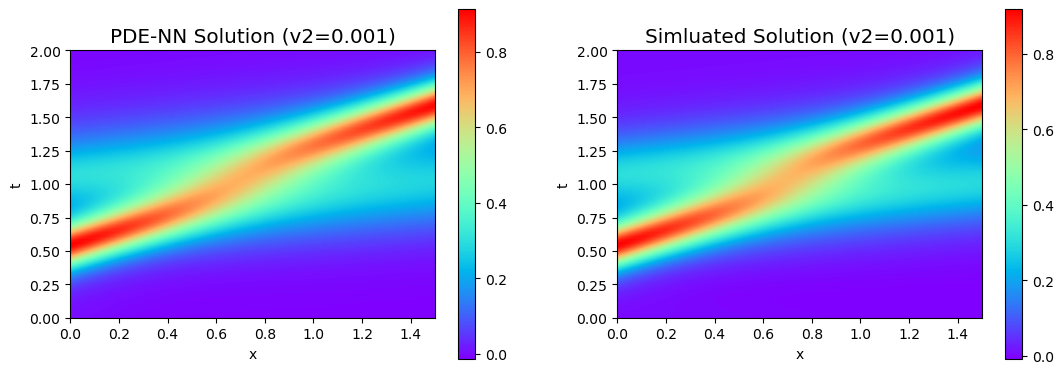

In [20]:
fig = plt.figure(figsize=(20, 10))
u_viz = (u.reshape(201, 77)).T 
ext = [x_l, x_u, 0 ,t_T]    # plot boundary 
ax1 = fig.add_subplot(2,3,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.55); 
plt.colorbar(mesh) 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('PDE-NN Solution (v2=%s)' %(v2), fontsize='x-large'); 

u_true = (batch_y.reshape(201, 77)).T

ax2 = fig.add_subplot(2,3,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.55); 
plt.colorbar(mesh2); 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('Simluated Solution (v2=%s)' %(v2), fontsize='x-large'); 

In [21]:
np.mean((u_viz - u_true)**2)

DeviceArray(7.565652e-05, dtype=float32)

In [22]:
np.save('kdv_cma_60s', (u_viz, u_true))